In [1]:
%matplotlib inline
import time
import numpy as np
import xesmf as xe
import xarray as xr
import netCDF4 as nc
import cmocean as cm
import cartopy.crs as ccrs
import matplotlib.ticker
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.gridspec as gridspec
import warnings
warnings.filterwarnings('ignore')

In [2]:
g = 9.8
nt = 236
rho0 = 1035.0
radius = 6371e+3
t_19cyc = np.arange(nt)

In [3]:
# tpgd = xr.open_dataset('/g/data/nm03/TPXO/grid_tpxo9.nc')
tpgd = xr.open_dataset('/g/data/nm03/TPXO9v5a/gridtpxo9v5a.nc')
mz_tpxo = np.array(tpgd.mz.transpose().fillna(1))
mz_tpxo[mz_tpxo==0]=np.nan
ny, nx  = np.array(tpgd.ny), np.array(tpgd.nx)

omega = np.full((nt,ny.size,nx.size),(2*np.pi/(12.4206014)))
lon_z = np.array(tpgd.lon_z.transpose())/180 *np.pi
lat_z = np.array(tpgd.lat_z.transpose())/180 *np.pi
lon_u = np.array(tpgd.lon_u.transpose())/180 *np.pi
lat_u = np.array(tpgd.lat_u.transpose())/180 *np.pi
lon_v = np.array(tpgd.lon_v.transpose())/180 *np.pi
lat_v = np.array(tpgd.lat_v.transpose())/180 *np.pi

dlat = lat_z[1,0]-lat_z[0,0]
dlon = lon_z[0,1]-lon_z[0,0]

0.3.0


In [4]:
# tpxo = xr.open_dataset('/g/data/nm03/TPXO/h_tpxo9.v1.nc')
tpxo = xr.open_dataset('/g/data/nm03/TPXO9v5a/h_tpxo9.v5a.nc')
elev_a = mz_tpxo * np.array(tpxo.ha.isel({'nc':0}).transpose())
elev_p = mz_tpxo * np.array(tpxo.hp.isel({'nc':0}).transpose())/180 *np.pi
elev_tpxo = (elev_a[None,:,:] * np.exp(1j*(omega * t_19cyc[:,None,None] - elev_p[None,:,:]))).real

In [5]:
# elev_r =  mz_tpxo * np.array(tpxo.hRe.isel({'nc':0}).transpose())
# elev_i =  mz_tpxo * np.array(tpxo.hIm.isel({'nc':0}).transpose())

# elev_r_recon = (elev_a * np.exp(1j*(-elev_p))).real
# elev_i_recon = (elev_a * np.exp(1j*(-elev_p))).imag

# print(np.nanmean(elev_r),np.nanmean(elev_r_recon))
# print(np.nanmean(elev_i),np.nanmean(elev_i_recon))

In [6]:
# tpxo_vel = xr.open_dataset('/g/data/nm03/TPXO/u_tpxo9.v1.nc')
tpxo_vel = xr.open_dataset('/g/data/nm03/TPXO9v5a/u_tpxo9.v5a.nc')
ua = mz_tpxo * np.array(tpxo_vel.Ua.isel({'nc':0}).transpose()) 
up = mz_tpxo * np.array(tpxo_vel.up.isel({'nc':0}).transpose())/180 *np.pi 
va = mz_tpxo * np.array(tpxo_vel.Va.isel({'nc':0}).transpose()) 
vp = mz_tpxo * np.array(tpxo_vel.vp.isel({'nc':0}).transpose())/180 *np.pi 

u = (ua[None,:,:] * np.exp(1j*(omega * t_19cyc[:,None,None] - up[None,:,:]))).real
v = (va[None,:,:] * np.exp(1j*(omega * t_19cyc[:,None,None] - vp[None,:,:]))).real

In [7]:
# ur = mz_tpxo * np.array(tpxo_vel.URe.isel({'nc':0}).transpose()) 
# ui = mz_tpxo * np.array(tpxo_vel.UIm.isel({'nc':0}).transpose()) 
# vr = mz_tpxo * np.array(tpxo_vel.VRe.isel({'nc':0}).transpose()) 
# vi = mz_tpxo * np.array(tpxo_vel.VIm.isel({'nc':0}).transpose())

# ur_recon = (ua * np.exp(-1j*up)).real
# vr_recon = (va * np.exp(-1j*vp)).real

# ui_recon = (ua * np.exp(-1j*up)).imag
# vi_recon = (va * np.exp(-1j*vp)).imag

# print(np.nanmean(ur), np.nanmean(ur_recon))
# print(np.nanmean(vr), np.nanmean(vr_recon))

# print(np.nanmean(ui), np.nanmean(ui_recon))
# print(np.nanmean(vi), np.nanmean(vi_recon))

### Interp eta to u and v points

In [8]:
start_time = time.time()

ds_elev_z = xr.Dataset(data_vars={"elev_tpxo": (('nt','ny','nx'), elev_tpxo),
                                 },
                       coords={"lon": (('ny', 'nx'), lon_z), 
                               "lat": (('ny', 'nx'), lat_z)})
ds_grid_u = xr.Dataset({"lat": (["ny","nx"], lat_u),
                        "lon": (["ny","nx"], lon_u)})
ds_grid_v = xr.Dataset({"lat": (["ny","nx"], lat_v),
                        "lon": (["ny","nx"], lon_v)})

regridder_z2u = xe.Regridder(ds_elev_z, ds_grid_u, "bilinear", extrap_method="inverse_dist")
regridder_z2v = xe.Regridder(ds_elev_z, ds_grid_v, "bilinear", extrap_method="inverse_dist")

ds_elev_u = regridder_z2u(ds_elev_z)
ds_elev_v = regridder_z2v(ds_elev_z)

end_time = time.time()
exe_time = float(end_time - start_time)
print("Execution time: %.1f seconds! \n" % exe_time)

Execution time: 224.5 seconds! 



In [9]:
elev_tpxo_u = np.array(ds_elev_u["elev_tpxo"])
elev_tpxo_v = np.array(ds_elev_v["elev_tpxo"])

In [10]:
veta = np.real( np.nanmean( (v * elev_tpxo_v) * np.cos(lat_v), axis=0 ))
ueta = np.real( np.nanmean( u * elev_tpxo_u, axis=0 ))
divP1 = 1/( radius*np.cos(lat_z[:-1,:]) ) * (veta[1:,:] - veta[:-1,:]) / dlat
divP2 = 1/( radius*np.cos(lat_z[:,:-1]) ) * (ueta[:,1:] - ueta[:,:-1]) / dlon     

In [11]:
start_time = time.time()

ds_divP_v = xr.Dataset(data_vars={"divP1": (('ny','nx'), divP1),
                                 },
                       coords={"lon": (('ny', 'nx'), lon_z[:-1,:]), 
                               "lat": (('ny', 'nx'), lat_z[:-1,:])})

ds_divP_u = xr.Dataset(data_vars={"divP2": (('ny','nx'), divP2),
                                 },
                       coords={"lon": (('ny', 'nx'), lon_z[:,:-1]), 
                               "lat": (('ny', 'nx'), lat_z[:,:-1])})

ds_grid_z = xr.Dataset({"lat": (["ny","nx"], lat_z),
                        "lon": (["ny","nx"], lon_z)})

regridder_div_v2z = xe.Regridder(ds_divP_v, ds_grid_z, "bilinear", extrap_method="inverse_dist")
regridder_div_u2z = xe.Regridder(ds_divP_u, ds_grid_z, "bilinear", extrap_method="inverse_dist")

ds_divP1_z = regridder_div_v2z(ds_divP_v)
ds_divP2_z = regridder_div_u2z(ds_divP_u)

end_time = time.time()
exe_time = float(end_time - start_time)
print("Execution time: %.1f seconds! \n" % exe_time)

Execution time: 136.3 seconds! 



In [12]:
P = g * rho0 * (ds_divP1_z["divP1"] + ds_divP2_z["divP2"]) 

In [13]:
dlat = np.full((ny.size,nx.size),np.nan) 
dlon = np.full((ny.size,nx.size),np.nan)
for j in range(ny.size):
    for i in range(nx.size):
        dlat[:,i] = np.squeeze(lat_u[:,i] - lat_v[:,i])*2
        dlon[j,:] = np.squeeze(lon_v[j,:] - lon_u[j,:])*2

In [14]:
lat_z = np.array(tpgd.lat_z.transpose())/180 *np.pi
dA = radius**2 * np.cos(lat_z) * (-dlat) * dlon * mz_tpxo
# fac_lat = xr.where((lat_z < 75) & (lat_z > -75), 1, np.nan)
# dA = dA * fac_lat

In [15]:
lat_z = np.array(tpgd.lat_z.transpose())/180 *np.pi
lon_z = np.array(tpgd.lon_z.transpose())/180 *np.pi

ds_dissip = xr.Dataset(data_vars={
                                  "TPXO_fluxes": (('ny','nx'), np.array(P)),
                                  "area": (('ny','nx'), np.array(dA)),
                                 },
                       coords={"lon": (('ny', 'nx'), np.rad2deg(lon_z)), 
                               "lat": (('ny', 'nx'), np.rad2deg(lat_z))})

In [16]:
hz_tpxo = tpgd.hz.transpose()
lat_z = tpgd.lat_z.transpose()

fac_dep = xr.where(hz_tpxo > 1000, 1, np.nan) 
fac_lat = xr.where((lat_z < 75) & (lat_z > -75), 1, np.nan)

TPXO_fluxes   = np.array(ds_dissip["TPXO_fluxes"]) * mz_tpxo

global_fluxes = np.nansum(TPXO_fluxes *dA) /1e+12
print('Global (75S - 75N, > 500m) M2 tidal energy fluxes: %.4fTW'%global_fluxes.real)

# global_dissip = np.nansum(TPXO_dissip *dA) /1e+12
# deep_dissip   = np.nansum(TPXO_dissip *dA *np.array(fac_dep)) /1e+12
# print('Global (75S - 75N, > 500m) M2 tidal energy dissipation: %.4fTW'%global_dissip)
# print('Open ocean (75S - 75N, > 1000m) M2 tidal energy dissipation: %.4fTW'%deep_dissip)
# print('Open ocean dissipation fraction: %d%%'%(deep_dissip/global_dissip*100))

Global (75S - 75N, > 500m) M2 tidal energy fluxes: -0.7291TW


In [17]:
depth = tpgd.hz.transpose()
depth_z = np.array(depth)
depth_z[depth_z==0]=np.nan
lat_z_deg = np.array(tpgd.lat_z.transpose())
lon_z_deg = np.array(tpgd.lon_z.transpose())

depth_da = xr.Dataset(data_vars={'depth_xr': (('yh','xh'), depth_z),
                                }, 
                      coords={'lon': (('yh', 'xh'), lon_z_deg),
                              'lat': (('yh', 'xh'), lat_z_deg)})
land = xr.where(np.isnan(depth_da.depth_xr[:,:].rename('land')), 1, np.nan)

In [18]:
TPXO_fluxes   = -np.array(ds_dissip["TPXO_fluxes"]) * mz_tpxo * 1e+3
print(np.nanmin(TPXO_fluxes),np.nanmax(TPXO_fluxes))

-6214078.745844756 6487332.035975996


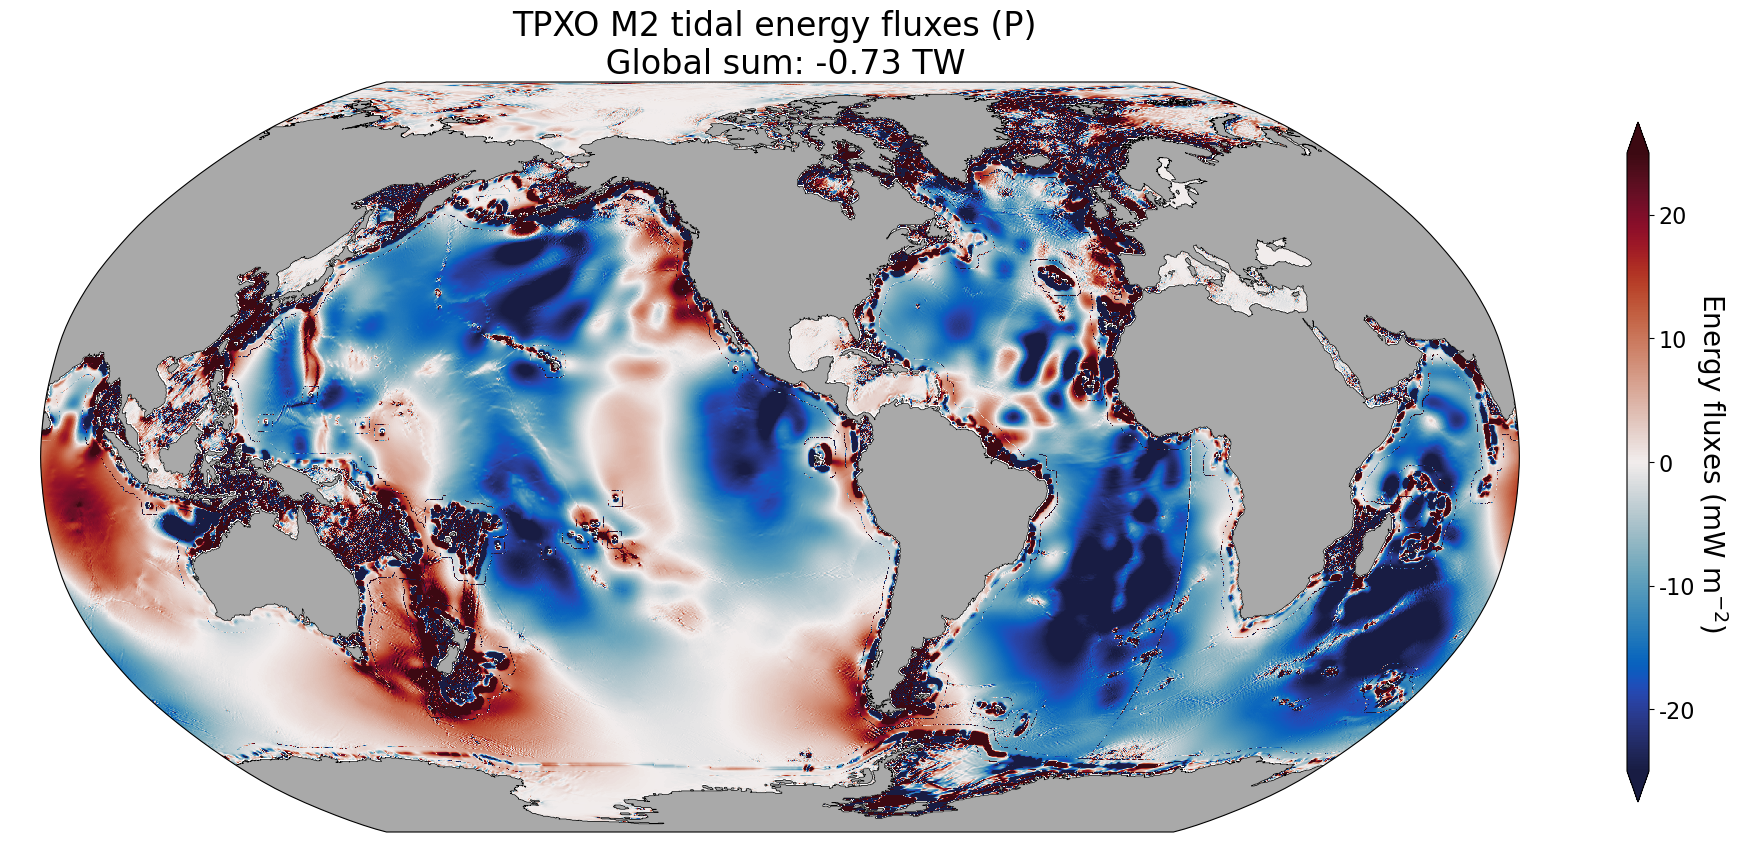

In [20]:
varlist = ['TPXO_fluxes']
title   = ['TPXO M2 tidal energy fluxes (P) \n Global sum: %.2f TW'%(global_fluxes)]
# tick_locs = np.array([1e-4,1e-3,1e-2,1e-1,1e-0])
# tick_labels = np.array(["10$^{-4}$","10$^{-3}$","10$^{-2}$","10$^{-1}$","10$^{0}$"])
tick_locs = np.array([-20,-10,0,10,20])
tick_labels = np.array(["-20","-10","0","10","20"])

fig = plt.figure(figsize=(22, 10))
axs = []

gridsubs = gridspec.GridSpec(1,1)
for gs in gridsubs:
    axs.append(plt.subplot(gs))

for I, (ax, var) in enumerate(zip(axs, varlist)):

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    
    ax = plt.axes(projection=ccrs.Robinson(central_longitude=-100))
    # Add model land mask
    land.plot.contourf(ax=ax, x='lon', y='lat', colors='darkgrey', zorder=2, transform=ccrs.PlateCarree(), add_colorbar=False)
    # Add model coastline
    land.fillna(0).plot.contour(ax=ax, x='lon', y='lat', colors='k', levels=[0, 1], transform=ccrs.PlateCarree(), add_colorbar=False, linewidths=0.5)

    p1 = ax.pcolormesh(lon_z_deg, lat_z_deg, globals()[var], transform=ccrs.PlateCarree(), cmap=cm.cm.balance, vmin=-25, vmax=25)
    # p1 = ax.pcolormesh(lon_z_deg, lat_z_deg, globals()[var], transform=ccrs.PlateCarree(), cmap=cm.cm.thermal, norm=LogNorm(vmin=1e-4, vmax=1e+0))
    plt.title(title[I],fontsize=24)
  
    if I==0:
        ax_cb = plt.axes([0.86, 0.13, 0.01, 0.68])
    
    cb1 = plt.colorbar(p1, cax=ax_cb, orientation='vertical', extend='both')
    cb1.ax.set_ylabel('Energy fluxes (mW m$^{-2}$)',fontsize=20,rotation=270,labelpad=25);
    cb1.ax.tick_params(labelsize=16)
    cb1.locator   = matplotlib.ticker.FixedLocator(tick_locs)
    cb1.formatter = matplotlib.ticker.FixedFormatter(tick_labels)

    if I==0:
        ax.set_position([0.1,0.1,0.75,0.75])
        
plt.savefig('/g/data/nm03/lxy581/exps_figs/TPXO_M2_P_lin.png', dpi=100, bbox_inches='tight')